# Models for ozone 

In this notebook, we develop the models for the transformed dataset considering the exogenous variable to be the **Ozone**.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import tqdm
from utilities import Utilities

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# models 
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
import statsmodels.api as sm
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor

# others
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures

from scipy.stats import jarque_bera

## Definitions for the notebook

In [4]:
# For local folder
IMAGES_FOLDER = "../notes/images/"
# For Google colab
#IMAGES_FOLDER = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/images/"

# For local folder
location = "../data/"
# For Google colab
#location = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

utility = Utilities()

%matplotlib inline

## Importing the dataset

In [5]:
air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p3.csv", index_col = 0)
air_data.weekend = air_data.weekend.astype(int)
air_data = air_data.reset_index().drop(columns="index")
air_data.head()

year  month  day  CodNum     Lat     Lon  Chuva   Pres     RS   Temp  ...  \
0  2011      1    2       1 -22.965 -43.180  3.617 -1.530 -1.128 -0.140  ...   
1  2011      1    2       7 -22.898 -43.222 -0.272 -1.513 -0.565  0.560  ...   
2  2011      1    2       3 -22.908 -43.178  3.617 -1.557 -0.720 -0.470  ...   
3  2011      1    2       8 -22.925 -43.233  3.617 -1.909 -0.194 -1.068  ...   
4  2011      1    2       7 -22.898 -43.222  3.617 -1.658 -0.567  0.548  ...   

   CO_lag24  CO_MA24  O3_lag1  O3_lag2  O3_lag24  O3_MA24  PM10_lag1  \
0    -0.763   -0.936   -0.738   -0.543    -1.190   -0.365      0.101   
1    -1.678   -1.232   -0.612   -0.997    -0.724   -0.187     -0.307   
2    -0.634   -0.166   -0.211   -0.717    -0.169   -0.027     -0.677   
3    -0.897   -1.283   -0.267   -0.184    -1.028    0.274     -0.773   
4    -1.591   -1.206   -1.300   -0.612    -1.099   -0.204     -0.484   

   PM10_lag2  PM10_lag24  PM10_MA24  
0      0.078       0.087      0.082  
1     -0.967      -1.858     -1.136  
2     -0.677      -1.617     -1.141  
3     -0.583       0.495     -1.061  
4     -0.307      -0.967     -1.136  

[5 rows x 34 columns]

## Inverse Power Transformation 

Just for future transformations on ozone data. 

In [6]:
air_data_ = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv", index_col = 0)

gases = ['CO', 'O3', 'PM10']

pt_gases = {key: PowerTransformer(method = 'yeo-johnson', 
                                  standardize=True).fit(air_data_[[key]]) for key in gases}

del air_data_

## Train and Test

In [7]:
df_train = air_data[air_data.train].drop(columns='train')
df_test = air_data[~air_data.train].drop(columns='train')

x_train = df_train.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])
x_test = df_test.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])

## Tijuca station

The chosen station to report more detailed results.

In [8]:
x_train_SP = x_train[x_train.CodNum == 8].drop(columns="CodNum")
x_test_SP = x_test[x_test.CodNum == 8] .drop(columns="CodNum")

y_train_o3 = df_train[df_train.CodNum==8].O3
y_test_o3 = df_test[df_test.CodNum==8].O3

del df_train, df_test

## Linear regression

In [9]:
x_train_SP_sm = sm.add_constant(x_train_SP)
x_test_SP_sm = sm.add_constant(x_test_SP)

reg = sm.OLS(y_train_o3, x_train_SP_sm)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 1.199e+04
Date:                Sun, 20 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:05:22   Log-Likelihood:                -20194.
No. Observations:               54290   AIC:                         4.044e+04
Df Residuals:                   54263   BIC:                         4.068e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2878      2.546     12.681      0.0

In [61]:
y_pred = res.predict(x_test_SP_sm)

y_train_pred = res.predict(x_train_SP_sm)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "simple_linear_regression", {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8517668189656552
MAE train set: 0.25780109884853836
RMSE train set: 0.350999594200755
R2 test set: 0.8370700290526956
MAE test set: 0.22463310207015727
RMSE test set: 0.3039159513047826


Let's look at the residuals

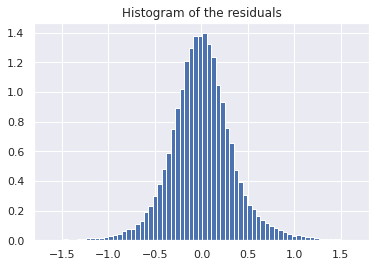

In [62]:
residuals = y_train_pred - y_train_o3
plt.hist(residuals, bins = 100, density = True)
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.savefig(IMAGES_FOLDER+"histogram_residuals_slr.eps", bbox_inches = 'tight')
plt.show()

In [10]:
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: 0.22558431082476935
Kurt: 2.8041868083755976
Jarque-Bera: Jarque_beraResult(statistic=18243.56064834909, pvalue=0.0)


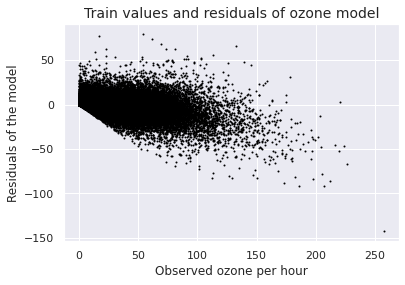

In [11]:
train_trans = pt_gases['O3'].inverse_transform(y_train_o3.values.reshape(-1,1))
pred_trans = pt_gases['O3'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'black')
plt.xlabel("Observed ozone per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of ozone model", fontsize = 14)
plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


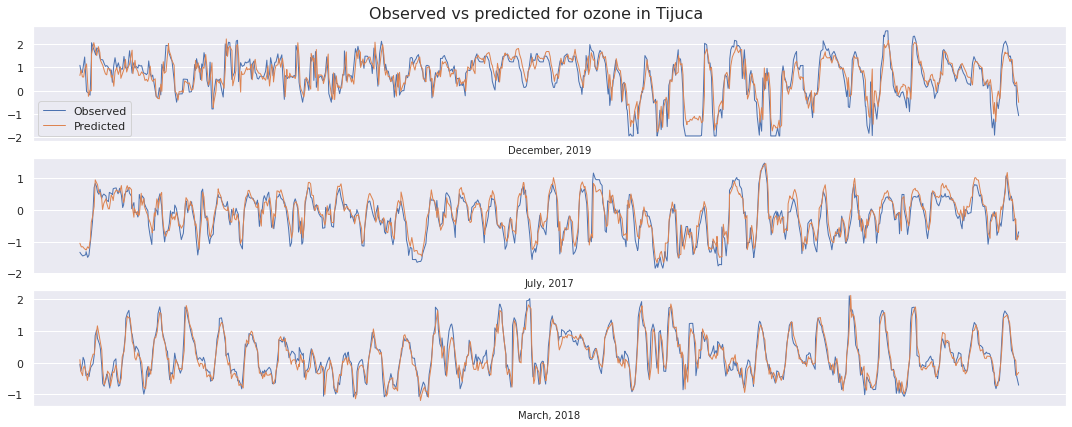

In [12]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

In [13]:
x_train_SP_sm = sm.add_constant(x_train_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2',
                                                        'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
x_test_SP_sm = sm.add_constant(x_test_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2', 
                                                       'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
test_values = [1,2,4,8,12,24,36,48,60,72,84,108]
r2_test_values = []

for i in test_values:
    
    x_train_SP_sm["O3_lag"] = y_train_o3.shift(i)
    x_test_SP_sm["O3_lag"] = y_test_o3.shift(i)

    x_train_SP_sm.dropna(inplace=True)
    x_test_SP_sm.dropna(inplace=True)
    y_train_o3_ = y_train_o3[i:]
    y_test_o3_ = y_test_o3[i:]

    res = sm.OLS(y_train_o3_, x_train_SP_sm).fit()
    y_pred = res.predict(x_test_SP_sm)

    r2_test_values.append(r2_score(y_test_o3_, y_pred))

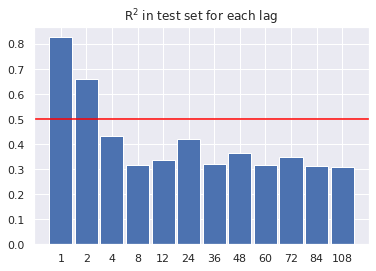

In [14]:
plt.bar([str(i) for i in test_values], r2_test_values, width = 0.9)
plt.axhline(0.5, color = 'red')
plt.title(r"R$^2$ in test set for each lag")
plt.savefig(IMAGES_FOLDER+"r2_test_per_lag.eps")
plt.show()

## Elastic-net Regression

For this model, polynomial and interaction terms can be added. This is due to the regularization term.

In [9]:
poly = PolynomialFeatures(2)

x_train_SP_poly = pd.DataFrame(poly.fit_transform(x_train_SP), 
                               columns = poly.get_feature_names(x_train_SP.columns), 
                               index = x_train_SP.index)
x_test_SP_poly = pd.DataFrame(poly.fit_transform(x_test_SP), 
                              columns = poly.get_feature_names(x_test_SP.columns),
                              index = x_test_SP.index)

In [87]:
model = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0],
                     alphas = range(1, 20), 
                     cv = 5, 
                     n_jobs = 2)

model.fit(x_train_SP_poly, y_train_o3)

y_pred = model.predict(x_test_SP_poly)

y_train_pred = model.predict(x_train_SP_poly)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

#utility.save_metrics("O3", 8, "elastic_net_regression", 
#                     {'alpha': float(model.alpha_), 'w_l1': model.l1_ratio_},    
#                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8516684349073814
MAE train set: 0.2578780268166075
RMSE train set: 0.35111605610301594
R2 test set: 0.8376312266550836
MAE test set: 0.22412968340950967
RMSE test set: 0.3033920942677412


In [97]:
ind = np.where(model.coef_ != 0)[0]
print(x_train_SP_poly.columns[ind])

Index(['year^2', 'year month', 'year day', 'year Chuva', 'year Pres',
       'year RS', 'year Temp', 'year UR', 'year Dir_Vento', 'year Vel_Vento',
       'year weekend', 'year season', 'year hour_sin', 'year hour_cos',
       'year CO_lag2', 'year CO_lag24', 'year O3_lag1', 'year O3_lag2',
       'year O3_lag24', 'year O3_MA24', 'year PM10_lag1', 'year PM10_lag2',
       'year PM10_lag24', 'year PM10_MA24'],
      dtype='object')


In [98]:
print("Proportion of non zero coefficients: {}".format(ind.shape[0]/model.coef_.shape[0]))

Proportion of non zero coefficients: 0.06349206349206349


In [99]:
residuals = y_train_pred - y_train_o3
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: 0.22870629624086342
Kurt: 2.7990550731638355
Jarque-Bera: Jarque_beraResult(statistic=18191.362889197648, pvalue=0.0)


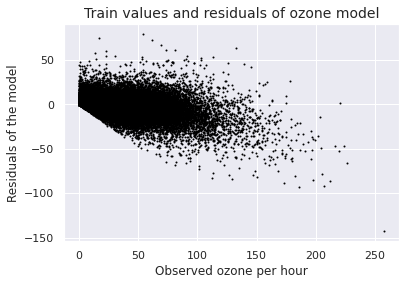

In [33]:
train_trans = pt_gases['O3'].inverse_transform(y_train_o3.values.reshape(-1,1))
pred_trans = pt_gases['O3'].inverse_transform(y_train_pred.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'black')
plt.xlabel("Observed ozone per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of ozone model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

In [40]:
y_pred = pd.Series(y_pred, index = y_test_o3.index)

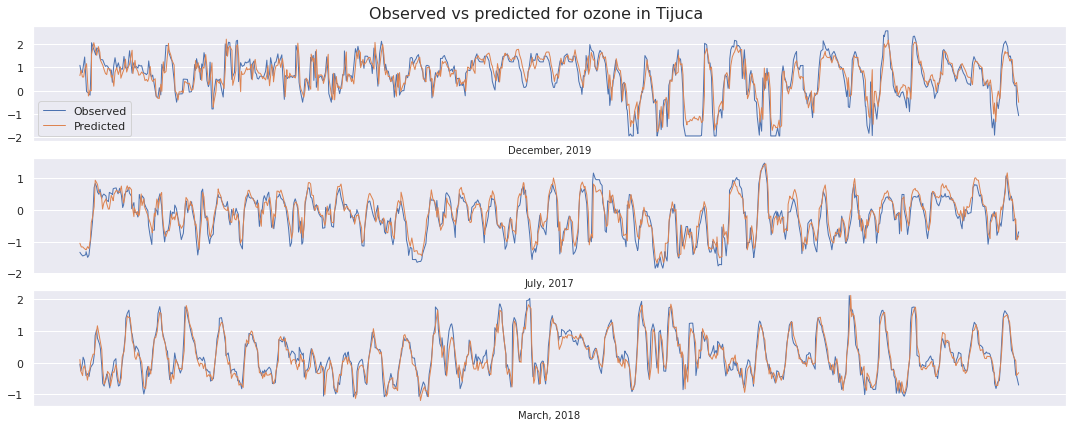

In [41]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Feature Selection + Linear regression

The Forward Feature Selection is performed with polynomial and interaction terms.

In [53]:
regr = LinearRegression()

best_features = utility.forward_selection(data = x_train_SP_poly, 
                                          target = y_train_o3,
                                          regr = regr, 
                                          k_fold = 5, 
                                          threshold = 0.001
                                         )

In [54]:
print(best_features)

['year O3_lag1', 'RS', 'RS hour_cos', 'year Vel_Vento', 'O3_lag2', 'year O3_MA24', 'hour_cos PM10_lag1', 'RS Temp', 'RS O3_lag2', 'O3_lag1^2']


In [63]:
x_train_SP_sm = sm.add_constant(x_train_SP_poly[best_features])
x_test_SP_sm = sm.add_constant(x_test_SP_poly[best_features])

reg = sm.OLS(y_train_o3, x_train_SP_sm)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 3.249e+04
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:24:29   Log-Likelihood:                -19246.
No. Observations:               54290   AIC:                         3.851e+04
Df Residuals:                   54279   BIC:                         3.861e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0889      0

In [64]:
y_pred = res.predict(x_test_SP_sm)

y_train_pred = res.predict(x_train_SP_sm)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "ffs_linear_regression", 
                     {'threshold': 0.001, 'best_features': best_features},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8568525486205607
MAE train set: 0.25105556691538305
RMSE train set: 0.34492582378790887
R2 test set: 0.8476290071863612
MAE test set: 0.21222743016951673
RMSE test set: 0.29390309102639167


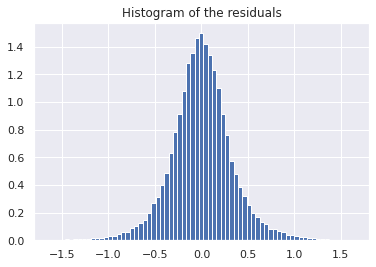

Skew: 0.142077714419295
Kurt: 3.0631685326062343
Jarque-Bera: Jarque_beraResult(statistic=21402.330786724535, pvalue=0.0)


In [59]:
residuals = y_train_pred - y_train_o3
plt.hist(residuals, bins = 100, density = True)
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.show()

print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

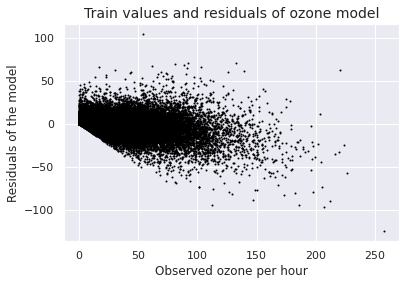

In [82]:
train_trans = pt_gases['O3'].inverse_transform(y_train_o3.values.reshape(-1,1))
pred_trans = pt_gases['O3'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'black')
plt.xlabel("Observed ozone per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of ozone model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

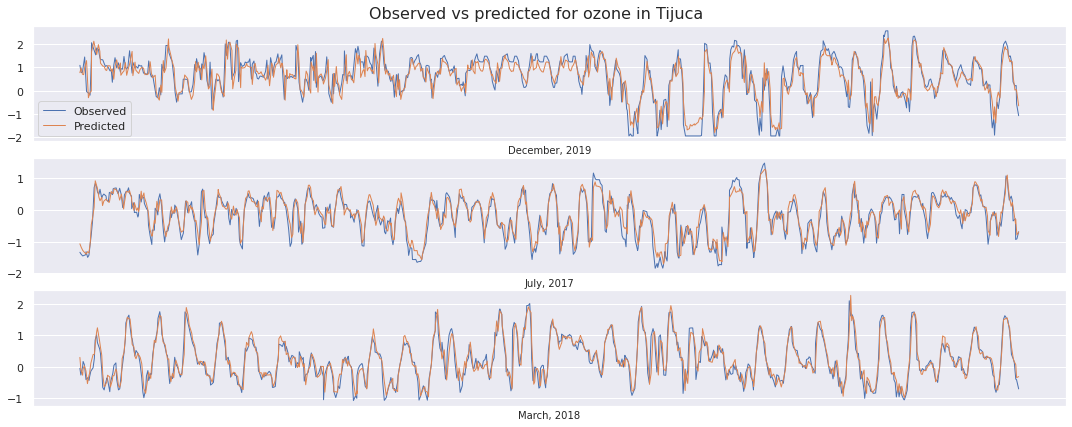

In [83]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Support vector machine

Considering the SVR with linear kernel. We make a grid search with cross-validation to estimate the best values from these above. 

In [26]:
scaler = StandardScaler()
svr = LinearSVR(epsilon = 0.1, 
                C = 1/2,
                max_iter = 2000)

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('svr', svr)])

param_grid = {
    'svr__epsilon': [0.001, 0.01, 0.1, 0.2, 0.3],
    'svr__C': np.logspace(-3,2,6)
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=-1)

search.fit(x_train_SP, y_train_o3)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameter (CV score=-0.126):
{'svr__C': 1.0, 'svr__epsilon': 0.2}


/home/lucasmoschen/anaconda3/envs/machineLearning/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


After the grid search with cross validation, the best parameters are used for the non linear kernel SRF to compare the waiting time.

In [27]:
epsilon = search.best_params_['svr__epsilon']
C = search.best_params_['svr__C']

In [28]:
%%time
svr = make_pipeline(StandardScaler(), 
                    SVR(kernel = 'rbf', 
                        degree = 2, 
                        epsilon = epsilon, 
                        C = C,
                        max_iter = 200000))

svr.fit(x_train_SP, y_train_o3)

CPU times: user 6min 28s, sys: 214 ms, total: 6min 28s
Wall time: 6min 28s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(degree=2, epsilon=0.2, max_iter=200000))])

In [29]:
y_pred = svr.predict(x_test_SP)

y_train_pred = svr.predict(x_train_SP)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "svr_rbf", 
                     {'epsilon': epsilon, 'C': C, 'degree': 2},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8998715568493787
MAE train set: 0.20822551670500006
RMSE train set: 0.2884779557905327
R2 test set: 0.7800601904639821
MAE test set: 0.2731731708798808
RMSE test set: 0.35310586187031484


With the linear kernel.

In [48]:
%%time
svr = make_pipeline(StandardScaler(), 
                    LinearSVR(epsilon = epsilon, 
                              C = C,
                              max_iter = 10000))

svr.fit(x_train_SP, y_train_o3)

CPU times: user 14.3 s, sys: 11.9 ms, total: 14.3 s
Wall time: 14.2 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.2, max_iter=10000))])

In [49]:
y_pred = svr.predict(x_test_SP)

y_train_pred = svr.predict(x_train_SP)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "svr_linear", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8508857835501964
MAE train set: 0.25544738222481506
RMSE train set: 0.3520411455224273
R2 test set: 0.8389959936313879
MAE test set: 0.2208836607466437
RMSE test set: 0.3021143446803956


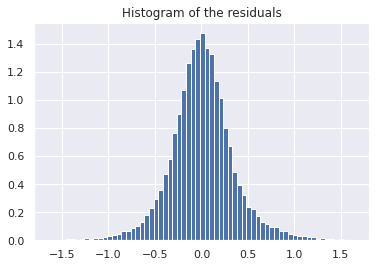

Skew: 0.22232536349934234
Kurt: 3.1218937138411493
Jarque-Bera: Jarque_beraResult(statistic=22488.362698947552, pvalue=0.0)


In [32]:
residuals = y_train_pred - y_train_o3
plt.hist(residuals, bins = 100, density = True)
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.show()

print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

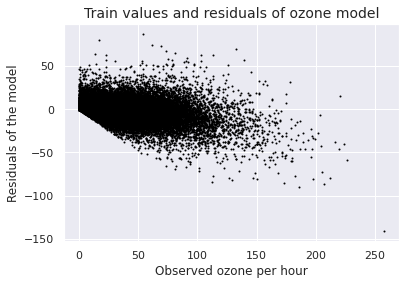

In [35]:
train_trans = pt_gases['O3'].inverse_transform(y_train_o3.values.reshape(-1,1))
pred_trans = pt_gases['O3'].inverse_transform(y_train_pred.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'black')
plt.xlabel("Observed ozone per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of ozone model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

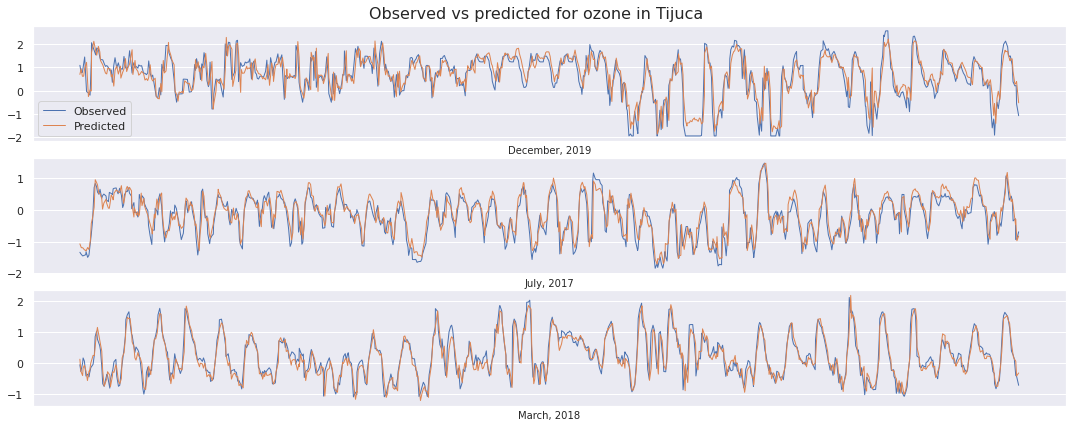

In [36]:
y_pred = pd.Series(y_pred, index = y_test_o3.index)

rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

Considering the best features selected by Linear Regression. 

In [42]:
best_features = ['year O3_lag1', 'RS', 'RS hour_cos', 'year Vel_Vento', 
                  'O3_lag2', 'year O3_MA24', 'hour_cos PM10_lag1', 'RS Temp', 
                  'RS O3_lag2', 'O3_lag1^2']

In [57]:
%%time
svr = make_pipeline(StandardScaler(), 
                    LinearSVR(epsilon = epsilon, 
                              C = C,
                              max_iter = 10000))

svr.fit(x_train_SP_poly[best_features], y_train_o3)

CPU times: user 8.11 s, sys: 7.98 ms, total: 8.12 s
Wall time: 8.59 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.2, max_iter=10000))])

In [58]:
y_pred = svr.predict(x_test_SP_poly[best_features])

y_train_pred = svr.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "svr_linear_best_features", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.856219774022448
MAE train set: 0.2488601537872511
RMSE train set: 0.3456873449588139
R2 test set: 0.8476903043148214
MAE test set: 0.2103936687699747
RMSE test set: 0.293843968133619


In [59]:
%%time
svr = make_pipeline(StandardScaler(), 
                    SVR(kernel = 'rbf', 
                        degree = 2, 
                        epsilon = epsilon, 
                        C = C,
                        max_iter = 200000))

svr.fit(x_train_SP_poly[best_features], y_train_o3)

CPU times: user 1min 52s, sys: 216 ms, total: 1min 52s
Wall time: 1min 52s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(degree=2, epsilon=0.2, max_iter=200000))])

In [60]:
y_pred = svr.predict(x_test_SP_poly[best_features])

y_train_pred = svr.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "svr_rbf_best_features", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8718601020960302
MAE train set: 0.23438066891423068
RMSE train set: 0.3263443415574066
R2 test set: 0.8506428432223636
MAE test set: 0.20926171142899516
RMSE test set: 0.29098193247121823


## Random Forest

In [31]:
scaler = StandardScaler()
rand_forest = RandomForestRegressor(n_estimators = 100, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs=2,
                                    )

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('forest', rand_forest)])

param_grid = {
    'forest__min_samples_split': [10, 20, 50, 100],
    'forest__ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1]
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=2)

search.fit(x_train_SP, y_train_o3)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.5s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    9.8s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Best parameter (CV score=-0.117):
{'forest__ccp_alpha': 0.0, 'forest__min_samples_split': 10}


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.3s finished


In [32]:
B = 100
c = search.best_params_['forest__ccp_alpha']
s = search.best_params_['forest__min_samples_split']

In [33]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = s, 
                                    max_features = 'sqrt',
                                    ccp_alpha = c,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP, y_train_o3)

RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=500, n_jobs=2)

In [35]:
y_pred = rand_forest.predict(x_test_SP)

y_train_pred = rand_forest.predict(x_train_SP)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "random_forest", 
                     {'s': s, 'c': c, 'B': 100},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9587003770934712
MAE train set: 0.13341225459948705
RMSE train set: 0.18527078568285346
R2 test set: 0.8476757768450589
MAE test set: 0.21397087247545368
RMSE test set: 0.2938579813832571


Changing the grid a little. 

In [37]:
rand_forest = RandomForestRegressor(n_estimators = 100, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs=2,
                                    verbose=4,
                                    )

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('forest', rand_forest)])

param_grid = {
    'forest__min_samples_split': [2, 5, 8],
    'forest__ccp_alpha': [0.0, 0.01, 1.]
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=2)

search.fit(x_train_SP, y_train_o3)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.6s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   10.7s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Best parameter (CV score=-0.116):
{'forest__ccp_alpha': 0.0, 'forest__min_samples_split': 2}


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   11.5s finished


In [38]:
B = 100
c = search.best_params_['forest__ccp_alpha']
s = search.best_params_['forest__min_samples_split']

In [39]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = s, 
                                    max_features = 'sqrt',
                                    ccp_alpha = c,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP, y_train_o3)

RandomForestRegressor(max_features='sqrt', n_estimators=500, n_jobs=2)

In [40]:
y_pred = rand_forest.predict(x_test_SP)

y_train_pred = rand_forest.predict(x_train_SP)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "random_forest", 
                     {'s': s, 'c': c, 'B': 100},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.982444951207825
MAE train set: 0.08733229921692859
RMSE train set: 0.12079109563275324
R2 test set: 0.8478992641217014
MAE test set: 0.2137701501463807
RMSE test set: 0.29364233076299284


In [43]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP_poly[best_features], y_train_o3)

RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=500, n_jobs=2)

In [44]:
y_pred = rand_forest.predict(x_test_SP_poly[best_features])

y_train_pred = rand_forest.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "random_forest_best_features", 
                     {'s': 10, 'c': 0, 'B': 500},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9535587735946462
MAE train set: 0.14060059458727733
RMSE train set: 0.19646524767728446
R2 test set: 0.8476837562450847
MAE test set: 0.212586587784166
RMSE test set: 0.29385028450798567


## Linear Regression + Expectation Maximization

For this model, we asked for help from `R`. 

In [10]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, r

norm = importr("norm")

Training the model with normal variables

In [13]:
df_train = utility.linear_regression_em_preparation(location)

In [14]:
X_r = FloatVector(df_train.values.flatten())
m = r['matrix'](X_r, ncol = df_train.shape[1], byrow = True)

s = norm.prelim_norm(m)  
theta = norm.em_norm(s)
params = norm.getparam_norm(s,theta,corr=False)
params = dict(zip(params.names, map(np.array,list(params))))

Iterations of EM: 
1...2...3...4...5...6...7...8...


In [15]:
mu_y = params['mu'][-1]
mu_X = params['mu'][:-1].reshape(-1,1)

Sigma_XX = params['sigma'][:-1,:-1]
Sigma_yX = params['sigma'][-1,:-1].reshape(1,-1)
Sigma_Xy = params['sigma'][:-1,-1].reshape(-1,1)
Sigma_yy = params['sigma'][-1,-1]

inv_Sigma_XX = np.linalg.inv(Sigma_XX)

beta = np.hstack([mu_y - Sigma_yX@inv_Sigma_XX@mu_X, Sigma_yX@inv_Sigma_XX]).reshape(-1,1)

In [24]:
y_pred = x_test_SP@beta[1:] + beta[0]

y_train_pred = x_train_SP@beta[1:] + beta[0]

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "linear_regression_em", 
                     {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)



R2 train set: 0.8514407753482623
MAE train set: 0.25792687435932227
RMSE train set: 0.3513853995800045
R2 test set: 0.8391213360179945
MAE test set: 0.2222474021991215
RMSE test set: 0.3019967230547992
